### Ordinary least squares Linear Regression. LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from preprocessing import mean_and_std
from regression_models import dosomething

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
outliers_df = pd.read_csv('geocoded.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    459 non-null    int64  
 1   bed             459 non-null    float64
 2   bath            459 non-null    float64
 3   acre_lot        459 non-null    float64
 4   zip_code        459 non-null    float64
 5   house_size      459 non-null    float64
 6   prev_sold_date  459 non-null    object 
 7   price           459 non-null    float64
 8   prev_sold_year  459 non-null    int64  
 9   zip_code_str    459 non-null    int64  
 10  latitude        459 non-null    float64
 11  longitude       459 non-null    float64
 12  county          459 non-null    int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 46.7+ KB


#### Find the zip code of that has the most houses.

In [4]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

2127.0

#### Find the rows of the zip code that has the most houses.

In [5]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [6]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 276 to 294
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    19 non-null     int64  
 1   bed             19 non-null     float64
 2   bath            19 non-null     float64
 3   acre_lot        19 non-null     float64
 4   zip_code        19 non-null     float64
 5   house_size      19 non-null     float64
 6   prev_sold_date  19 non-null     object 
 7   price           19 non-null     float64
 8   prev_sold_year  19 non-null     int64  
 9   zip_code_str    19 non-null     int64  
 10  latitude        19 non-null     float64
 11  longitude       19 non-null     float64
 12  county          19 non-null     int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 2.1+ KB


#### Create an object to pass to the function that will normalize the data

In [7]:
params = {
    "data":one_zipcode_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = one_zipcode_df
normalize_df.tail()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
290,290,1.0,1.0,0.01,2127.0,550.0,2020-04-09,599000.0,2020,2127,42.334992,-71.039093,3
291,291,1.0,1.0,0.23,2127.0,1039.0,2020-06-26,869000.0,2020,2127,42.334992,-71.039093,3
292,292,3.0,2.0,0.23,2127.0,1574.0,2019-12-31,1598000.0,2019,2127,42.334992,-71.039093,3
293,293,2.0,2.0,0.03,2127.0,1193.0,2019-01-31,875000.0,2019,2127,42.334992,-71.039093,3
294,294,2.0,2.0,0.23,2127.0,1140.0,2018-06-18,1049000.0,2018,2127,42.334992,-71.039093,3


#### Create a variable for the correlation of the normalized data

In [8]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.226971
bed               0.648117
bath              0.647215
house_size        0.921788
prev_sold_year   -0.154952
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

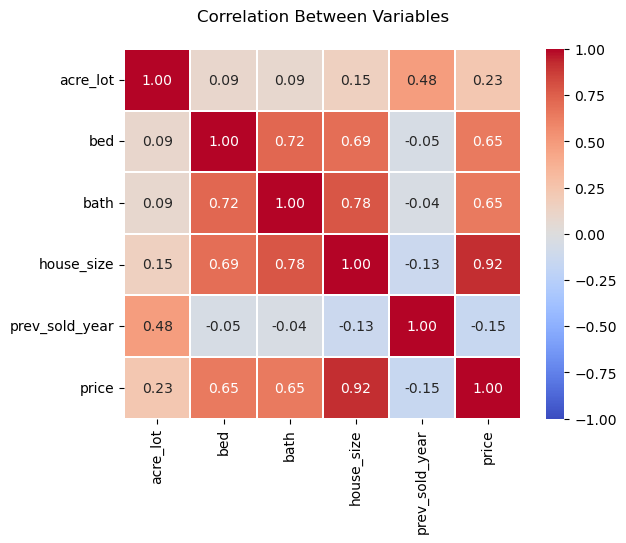

In [9]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [10]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'acre_lot', 'bed', 'bath']


#### Create common variables to store frequently used values.

In [11]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [12]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [13]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [14]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Use Grid Search CV to find the best Hyperparameters for Linear Regression

#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [15]:
linear_bp = dosomething("linear","Best Params", normalize_df, features, "price")
results_dict_append(linear_bp["results"])
linear_bp_predict = linear_bp["predictions"]

The selected features are: ['latitude', 'longitude', 'acre_lot', 'bed', 'bath']
Best Params EVS = 0.009793441
Best Params MSE = 120,169,307,096.928299
Best Params MAE = 315,352.476958
Best Params R2 = -0.071071
Best Params Fit Time = 0.001712799072265625


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [16]:
linear_sfm = dosomething("linear","Select From Model", normalize_df, features, "price")
results_dict_append(linear_sfm["results"])
linear_sfm_predict = linear_sfm["predictions"]

The selected features are: ['latitude', 'longitude']
Select From Model EVS = -0.000000000
Select From Model MSE = 216,620,566,134.122284
Select From Model MAE = 325,376.923077
Select From Model R2 = -0.930742
Select From Model Fit Time = 0.0011720657348632812


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [17]:
linear_sfs = dosomething("linear","Sequential Feature Selector", normalize_df, features, "price")
results_dict_append(linear_sfs["results"])
linear_sfs_predict = linear_sfs["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath']
Sequential Feature Selector EVS = -0.014661771
Sequential Feature Selector MSE = 126,173,792,962.963013
Sequential Feature Selector MAE = 316,388.888889
Sequential Feature Selector R2 = -0.124589
Sequential Feature Selector Fit Time = 0.0


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [18]:
linear_rfe = dosomething("linear","Recursive Feature Elimination", normalize_df, features, "price")
results_dict_append(linear_rfe["results"])
linear_rfe_predict = linear_rfe["predictions"]

The selected features are: ['latitude', 'longitude', 'acre_lot', 'bath']
Recursive Feature Elimination EVS = -0.020393418
Recursive Feature Elimination MSE = 124,112,070,932.307205
Recursive Feature Elimination MAE = 317,928.144519
Recursive Feature Elimination R2 = -0.106213
Recursive Feature Elimination Fit Time = 0.0006044864654541016


### Use Grid Search CV to find the best Parameters for Polynomial Regression

In [19]:
pipeline_gscv = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('poly_model', LinearRegression())
])

pipeline_params={"poly_features__degree":[1,2,3,4,5],"poly_features__include_bias":[False],"poly_model__fit_intercept":[True]}
grid_searchcv = GridSearchCV(pipeline_gscv, param_grid=pipeline_params, cv=5, verbose=1)

In [20]:
grid_searchcv.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly_features', PolynomialFeatures()),
                                       ('poly_model', LinearRegression())]),
             param_grid={'poly_features__degree': [1, 2, 3, 4, 5],
                         'poly_features__include_bias': [False],
                         'poly_model__fit_intercept': [True]},
             verbose=1)

In [21]:
print(f"Best parameters found: {grid_searchcv.best_params_}")

Best parameters found: {'poly_features__degree': 1, 'poly_features__include_bias': False, 'poly_model__fit_intercept': True}


In [22]:
pipeline_params = {}
for what in grid_searchcv.best_params_:
    if pipeline_params.get(what) == None:
        pipeline_params[what] = []
    pipeline_params[what].append(grid_searchcv.best_params_[what])
pipeline_params

{'poly_features__degree': [1],
 'poly_features__include_bias': [False],
 'poly_model__fit_intercept': [True]}

In [23]:
poly_bp = dosomething("linear","PolynomialFeatures", normalize_df, features, "price", pipeline_params)
results_dict_append(poly_bp["results"])
poly_predict = poly_bp["predictions"]

PolynomialFeatures EVS = 0.009793441
PolynomialFeatures MSE = 120,169,307,096.928345
PolynomialFeatures MAE = 315,352.476958
PolynomialFeatures R2 = -0.071071
PolynomialFeatures Fit Time = 0.002858734130859375


#### Graphing the results works best when the data is provided in a DataFrame.

In [24]:
poly_predict_df = pd.DataFrame(poly_predict).reset_index()
poly_predict_df.rename(columns={0: "prediction"},inplace=True)

linear_bp_predict = pd.DataFrame(linear_bp_predict).reset_index()
linear_bp_predict.rename(columns={0: "prediction"},inplace=True)

linear_sfm_predict_df = pd.DataFrame(linear_sfm_predict).reset_index()
linear_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

linear_sfs_predict_df = pd.DataFrame(linear_sfs_predict).reset_index()
linear_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

linear_rfe_predict_df = pd.DataFrame(linear_rfe_predict).reset_index()
linear_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

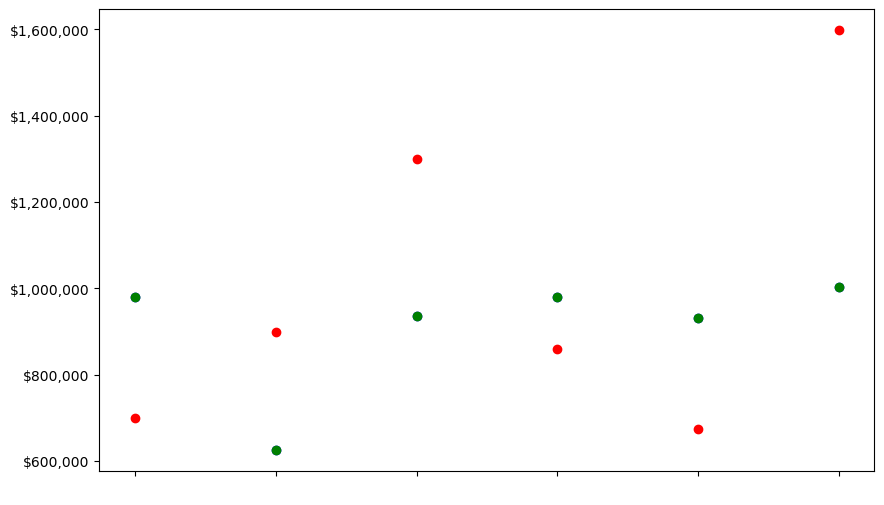

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(poly_predict_df.index,poly_predict_df["prediction"], color="blue")
plt.scatter(linear_bp_predict.index,linear_bp_predict["prediction"], color="green")
plt.show()

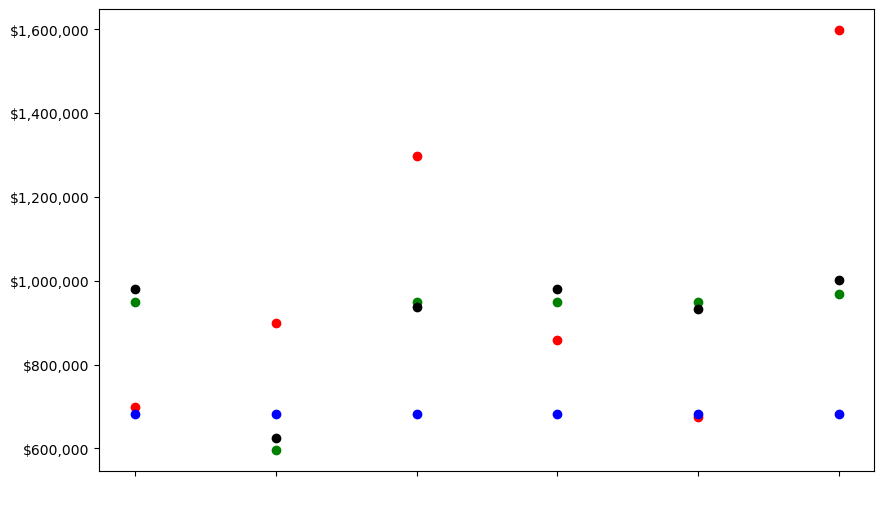

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(linear_sfs_predict_df.index,linear_sfs_predict_df["prediction"], color="green")
plt.scatter(linear_sfm_predict_df.index,linear_sfm_predict_df["prediction"], color="blue")
plt.scatter(linear_bp_predict.index,linear_bp_predict["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [27]:
results_dict

{'model': ['Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination',
  'PolynomialFeatures'],
 'explained variance score': ['0.009793441',
  '-0.000000000',
  '-0.014661771',
  '-0.020393418',
  '0.009793441'],
 'mae score': ['315,352.476958',
  '325,376.923077',
  '316,388.888889',
  '317,928.144519',
  '315,352.476958'],
 'mse score': ['120,169,307,096.928299',
  '216,620,566,134.122284',
  '126,173,792,962.963013',
  '124,112,070,932.307205',
  '120,169,307,096.928345'],
 'r2 score': ['-0.071071', '-0.930742', '-0.124589', '-0.106213', '-0.071071'],
 'mean fit time': [0.001712799072265625,
  0.0011720657348632812,
  0.0,
  0.0006044864654541016,
  0.002858734130859375]}

In [28]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Best Params,0.009793441,"315,352.476958","120,169,307,096.928299",-0.071071,0.001713
Select From Model,-0.000000000,"325,376.923077","216,620,566,134.122284",-0.930742,0.001172
Sequential Feature Selector,-0.014661771,"316,388.888889","126,173,792,962.963013",-0.124589,0.000000
Recursive Feature Elimination,-0.020393418,"317,928.144519","124,112,070,932.307205",-0.106213,0.000604
PolynomialFeatures,0.009793441,"315,352.476958","120,169,307,096.928345",-0.071071,0.002859
